The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested.

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.

The telescope covers around one quarter of the earth's sky - therefore focuses on the northern part of the sky.

In [ ]:
%pip install astropy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/DR18.csv')

#PhotoObj Features:#
objid: A unique identifier for the object.

ra (Right Ascension): Angular distance measured eastward along the celestial equator, specifying the object's position on the sky.

dec (Declination): The angular distance of an object north or south of the celestial equator.

u, g, r, i, z: Magnitude measurements in the Thuan-Gunn system for different bands (filters) of the telescope, indicating the brightness of the object in those bands.

run: The specific scan number during which the image was captured.

rereun: Specifies how the image was processed or reprocessed.

camcol (Camera Column): The scanline within the run, identifying the camera column.

field: A section of the image, corresponding to a 2048x1489 pixel area.


#SpecObj Features:#
specobjid: A unique identifier for the spectroscopic object.

class: The type of object (galaxy, star, or quasar).

redshift: The shift in the object's light to longer wavelengths, indicating how fast it's moving away from us.

mjd (Modified Julian Date): The date of the observation in Modified Julian Date format.

plate: The serial number of the spectroscopic plate used during the observation.

fiberid: The ID of the optical fiber used to direct light from the object to the spectrograph.

Data Exploration and Analysis

Basic stats about our dataset

In [ ]:
data

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237665e+18,214.775024,26.231389,18.91452,17.82512,17.40111,17.12318,16.99686,4649,301,3,203,2.394797e+18,GALAXY,0.015198,2127,53859,27
1,1.237665e+18,190.979819,29.630396,18.93076,17.07127,16.13052,15.68037,15.34830,4649,301,3,61,2.518670e+18,GALAXY,0.103481,2237,53828,117
2,1.237665e+18,222.901700,24.065934,18.96398,18.00796,17.67222,17.42770,17.28470,4649,301,3,254,2.414085e+18,GALAXY,0.039642,2144,53770,567
3,1.237665e+18,211.236033,27.007872,19.07693,18.07678,17.46506,17.30033,16.90555,4649,301,3,181,2.390350e+18,GALAXY,0.157561,2123,53793,235
4,1.237662e+18,219.069523,47.597442,17.68583,16.78106,16.49471,16.39366,16.37046,3918,301,4,154,1.884871e+18,STAR,-0.000300,1674,53464,416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237676e+18,70.901389,-6.158416,19.44401,16.87587,15.77122,15.37750,15.16919,7178,301,3,16,3.312459e+18,STAR,0.000161,2942,54521,223
99996,1.237675e+18,177.345861,-1.084221,17.65613,19.66116,18.57861,17.91094,18.93691,6793,301,1,112,3.198381e+17,GALAXY,0.020398,284,51943,300
99997,1.237649e+18,139.006180,-0.524955,17.53905,17.37486,17.52401,17.07631,16.51648,756,301,2,155,5.314509e+17,STAR,0.000204,472,51955,95
99998,1.237649e+18,163.805116,-0.572176,18.63258,17.59472,17.15296,16.96552,16.87494,756,301,2,320,3.107770e+17,STAR,0.000948,276,51909,104


In [ ]:
df = data.copy()

In [ ]:
df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237665e+18,214.775024,26.231389,18.91452,17.82512,17.40111,17.12318,16.99686,4649,301,3,203,2.394797e+18,GALAXY,0.015198,2127,53859,27
1,1.237665e+18,190.979819,29.630396,18.93076,17.07127,16.13052,15.68037,15.34830,4649,301,3,61,2.518670e+18,GALAXY,0.103481,2237,53828,117
2,1.237665e+18,222.901700,24.065934,18.96398,18.00796,17.67222,17.42770,17.28470,4649,301,3,254,2.414085e+18,GALAXY,0.039642,2144,53770,567
3,1.237665e+18,211.236033,27.007872,19.07693,18.07678,17.46506,17.30033,16.90555,4649,301,3,181,2.390350e+18,GALAXY,0.157561,2123,53793,235
4,1.237662e+18,219.069523,47.597442,17.68583,16.78106,16.49471,16.39366,16.37046,3918,301,4,154,1.884871e+18,STAR,-0.000300,1674,53464,416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237676e+18,70.901389,-6.158416,19.44401,16.87587,15.77122,15.37750,15.16919,7178,301,3,16,3.312459e+18,STAR,0.000161,2942,54521,223
99996,1.237675e+18,177.345861,-1.084221,17.65613,19.66116,18.57861,17.91094,18.93691,6793,301,1,112,3.198381e+17,GALAXY,0.020398,284,51943,300
99997,1.237649e+18,139.006180,-0.524955,17.53905,17.37486,17.52401,17.07631,16.51648,756,301,2,155,5.314509e+17,STAR,0.000204,472,51955,95
99998,1.237649e+18,163.805116,-0.572176,18.63258,17.59472,17.15296,16.96552,16.87494,756,301,2,320,3.107770e+17,STAR,0.000948,276,51909,104


In [ ]:
print(data.dtypes)

objid        float64
ra           float64
dec          float64
u            float64
g            float64
r            float64
i            float64
z            float64
run            int64
rerun          int64
camcol         int64
field          int64
specobjid    float64
class         object
redshift     float64
plate          int64
mjd            int64
fiberid        int64
dtype: object


In [ ]:
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237663e+18,177.373612,25.093908,18.637564,17.407615,16.882776,16.627404,16.469266,3974.352780,301.0,3.274110,186.301170,2.919558e+18,0.171130,2593.004460,53917.133310,341.859000
std,7.270949e+12,78.078701,20.577267,0.832058,0.986055,1.133157,1.210276,1.281926,1692.899859,0.0,1.620975,140.801444,2.495879e+18,0.438558,2216.771531,1549.002722,217.118311
min,1.237646e+18,0.013061,-19.495456,10.611810,9.668339,9.005167,8.848403,8.947795,109.000000,301.0,1.000000,11.000000,2.994897e+17,-0.004268,266.000000,51608.000000,1.000000
25%,1.237658e+18,136.201282,6.760243,18.211350,16.851275,16.195873,15.865040,15.621230,2826.000000,301.0,2.000000,85.000000,1.335398e+18,0.000000,1186.000000,52734.000000,160.000000
50%,1.237662e+18,180.324646,24.050795,18.872410,17.516110,16.891335,16.600505,16.430530,3900.000000,301.0,3.000000,152.000000,2.355424e+18,0.045669,2092.000000,53727.500000,327.000000
75%,1.237667e+18,224.603842,40.420272,19.273370,18.056393,17.586313,17.345850,17.235270,5061.000000,301.0,5.000000,248.000000,3.276507e+18,0.095410,2910.000000,54586.000000,502.000000
max,1.237681e+18,359.999615,84.490494,19.599950,19.974990,31.990100,32.141470,29.383740,8162.000000,301.0,6.000000,982.000000,1.412681e+19,7.011245,12547.000000,58932.000000,1000.000000


In [ ]:
df['class'].value_counts()

,count
class,
GALAXY,51141
STAR,38227
QSO,10632


Text(0.5, 1.0, 'Class Categories')

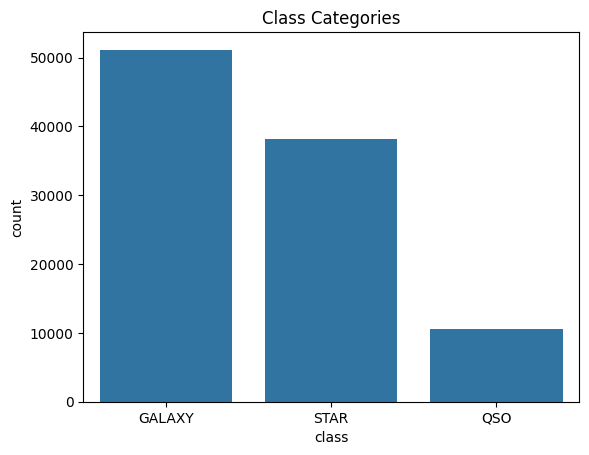

In [ ]:
sns.countplot(x = df['class'])
plt.title('Class Categories')

In [ ]:
#Drop more unnecessary columns
df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
df

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,214.775024,26.231389,18.91452,17.82512,17.40111,17.12318,16.99686,GALAXY,0.015198,2127,53859,27
1,190.979819,29.630396,18.93076,17.07127,16.13052,15.68037,15.34830,GALAXY,0.103481,2237,53828,117
2,222.901700,24.065934,18.96398,18.00796,17.67222,17.42770,17.28470,GALAXY,0.039642,2144,53770,567
3,211.236033,27.007872,19.07693,18.07678,17.46506,17.30033,16.90555,GALAXY,0.157561,2123,53793,235
4,219.069523,47.597442,17.68583,16.78106,16.49471,16.39366,16.37046,STAR,-0.000300,1674,53464,416
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70.901389,-6.158416,19.44401,16.87587,15.77122,15.37750,15.16919,STAR,0.000161,2942,54521,223
99996,177.345861,-1.084221,17.65613,19.66116,18.57861,17.91094,18.93691,GALAXY,0.020398,284,51943,300
99997,139.006180,-0.524955,17.53905,17.37486,17.52401,17.07631,16.51648,STAR,0.000204,472,51955,95
99998,163.805116,-0.572176,18.63258,17.59472,17.15296,16.96552,16.87494,STAR,0.000948,276,51909,104


In [ ]:
df.shape

(100000, 12)

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

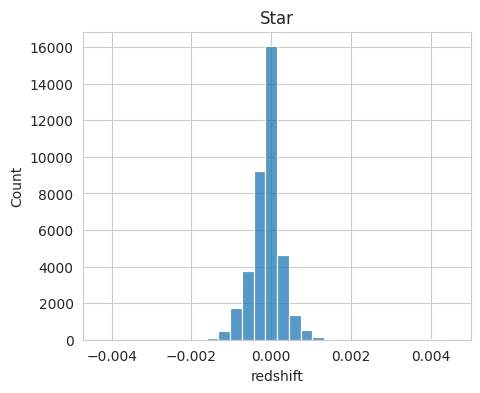

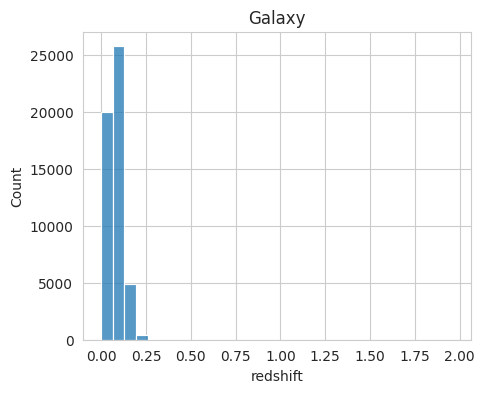

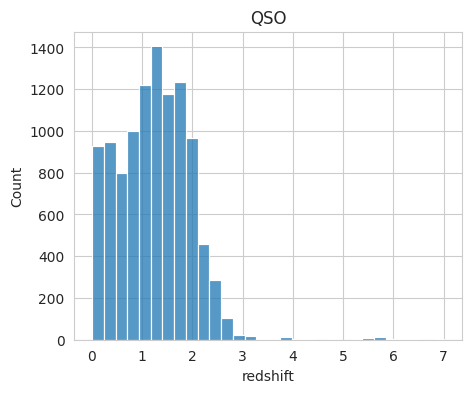

In [ ]:
#Correlation heatmap
# Create a figure with subplots
plt.figure(figsize=(5, 4))

# Plot the first displot (Star)
sns.histplot(df[df['class']=='STAR'].redshift, bins=30, kde=False)
plt.title('Star')
plt.show()

plt.figure(figsize=(5, 4))
# Plot the second displot (Galaxy)
sns.histplot(df[df['class']=='GALAXY'].redshift, bins=30, kde=False)
plt.title('Galaxy')
plt.show()

plt.figure(figsize=(5, 4))
# Plot the third displot (QSO)
sns.histplot(df[df['class']=='QSO'].redshift, bins=30, kde=False)
plt.title('QSO')
plt.show()

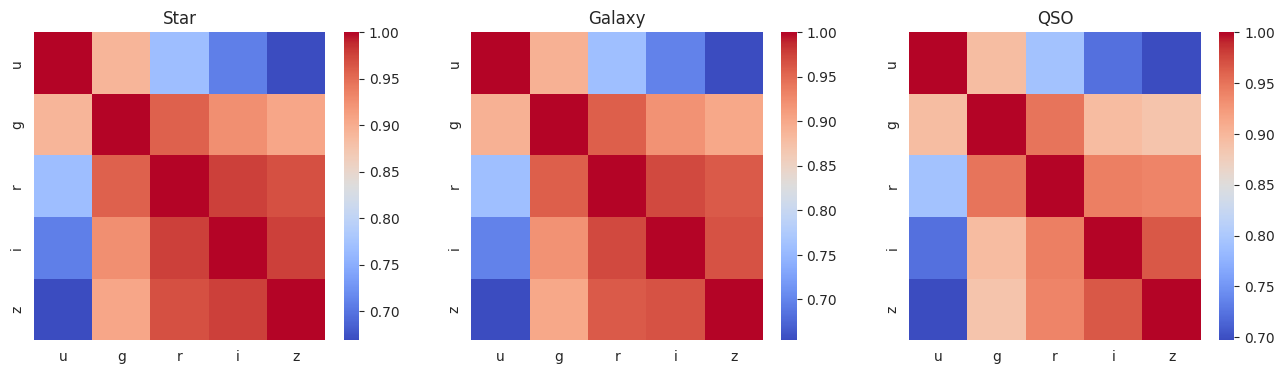

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)

ax = sns.heatmap(df[df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')

ax = sns.heatmap(df[df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')

ax = sns.heatmap(df[df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

In [ ]:
galaxy = df[df['class']=='GALAXY']
star = df[df['class']=='STAR']
qso = df[df['class']=='QSO']

In [ ]:
from astropy.coordinates import Angle

ra1 = Angle(galaxy['ra'], u.degree)
dec1 = Angle(galaxy['dec'], u.degree)
coords1 = SkyCoord(ra=ra1, dec=dec1, frame='icrs')

ra2 = Angle(star['ra'], u.degree)
dec2 = Angle(star['dec'], u.degree)
coords2 = SkyCoord(ra=ra2, dec=dec2, frame='icrs')

ra3 = Angle(qso['ra'], u.degree)
dec3 = Angle(qso['dec'], u.degree)
coords3 = SkyCoord(ra=ra3, dec=dec3, frame='icrs')

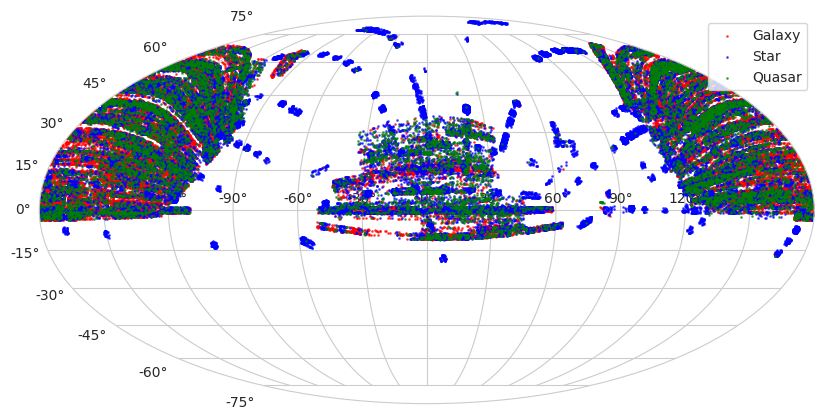

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(coords1.ra.wrap_at(180*u.degree).radian, coords1.dec.radian, s=1,c='r',alpha=0.6,label='Galaxy')
ax.scatter(coords2.ra.wrap_at(180*u.degree).radian, coords2.dec.radian,s=1,c='b',alpha=0.6,label='Star')
ax.scatter(coords3.ra.wrap_at(180*u.degree).radian, coords3.dec.radian, s=1,c='g',alpha=0.6,label='Quasar')

#change the marker size manually for the legend
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
#lgnd.legend_handles[0]._sizes = [30]
#lgnd.legend_handles[1]._sizes = [30]
#lgnd.legend_handles[2]._sizes = [30]
ax.grid(True)
plt.show()

In [ ]:
# Count rows with missing values
rows_with_missing_values = df.isnull().any(axis=1).sum()
print("Total rows with missing values:", rows_with_missing_values)

Total rows with missing values: 0


In [ ]:
df_fe = df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(df_fe['class'])
df_fe['class'] = y_encoded
df_fe.head(10)

# 0 means galaxy
# 1 means quasar
# 2 means star


,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,214.775024,26.231389,18.91452,17.82512,17.40111,17.12318,16.99686,0,0.015198,2127,53859,27
1,190.979819,29.630396,18.93076,17.07127,16.13052,15.68037,15.34830,0,0.103481,2237,53828,117
2,222.901700,24.065934,18.96398,18.00796,17.67222,17.42770,17.28470,0,0.039642,2144,53770,567
3,211.236033,27.007872,19.07693,18.07678,17.46506,17.30033,16.90555,0,0.157561,2123,53793,235
4,219.069523,47.597442,17.68583,16.78106,16.49471,16.39366,16.37046,2,-0.000300,1674,53464,416
5,221.437519,46.668078,18.85805,17.89683,17.56354,17.43642,17.43742,2,-0.000266,8489,57483,512
6,224.606885,45.417371,19.21197,17.94139,18.10692,18.25467,18.35545,2,-0.000296,1676,53147,461
7,226.225047,44.805855,18.88322,17.75448,17.29257,17.08128,16.98397,2,-0.000491,3390,54945,347
8,227.014705,44.493184,18.16604,17.21939,16.96849,16.85668,16.82426,2,-0.000342,8519,58198,576
9,227.721037,44.084254,17.70671,16.48556,16.03044,15.87200,15.81889,2,-0.000510,3390,54945,149


Data preprocessing

In [ ]:
import pickle

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe
new_df = pd.concat((df_fe, pd.DataFrame(ugriz)), axis=1)
new_df.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
new_df.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
new_df.head()

# Make pickle file of our model
pickle.dump(pca, open("/content/pca.pkl", "wb"))


In [ ]:
#Perform feature scaling
scaler = MinMaxScaler()
sdss = scaler.fit_transform(new_df.drop('class', axis=1))

# Make pickle file of our model
pickle.dump(scaler, open("/content/scalar.pkl", "wb"))

In [ ]:
scalerMod = MinMaxScaler()
sdssNew = scalerMod.fit_transform(new_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sdss, new_df['class'], test_size=0.33)

In [ ]:
import time

In [ ]:
%pip install scikit-plot

The Model

XGBoost is an optimized distributed gradient boosting library designed for efficient and scalable training of machine learning models. It is an ensemble learning method that combines the predictions of multiple weak models to produce a stronger prediction. XGBoost stands for “Extreme Gradient Boosting” and it has become one of the most popular and widely used machine learning algorithms

In [ ]:
xgb = XGBClassifier(n_estimators=100)

training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds_test = xgb.predict(X_test)
prediction_end = time.perf_counter()

prediction_start = time.perf_counter()
preds_train = xgb.predict(X_train)
prediction_end = time.perf_counter()

acc_xgb_test = (preds_test == y_test).sum().astype(float) / len(preds_test)*100
acc_xgb_train = (preds_train == y_train).sum().astype(float) / len(preds_train)*100

xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("XGBoost's prediction accuracy for training data is: %3.2f" % (acc_xgb_train))
print("XGBoost's prediction accuracy for testing data is: %3.2f" % (acc_xgb_test))
print("Time consumed for training: %4.3f seconds" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

# Make pickle file of our model
pickle.dump(xgb, open("/content/finalModel.pkl", "wb"))

# import scikitplot.estimators as esti
# esti.plot_learning_curve(xgb, X_train, y_train)
# plt.show()

XGBoost's prediction accuracy for training data is: 99.90
XGBoost's prediction accuracy for testing data is: 99.08
Time consumed for training: 2.396 seconds
Time consumed for prediction: 0.35765 seconds


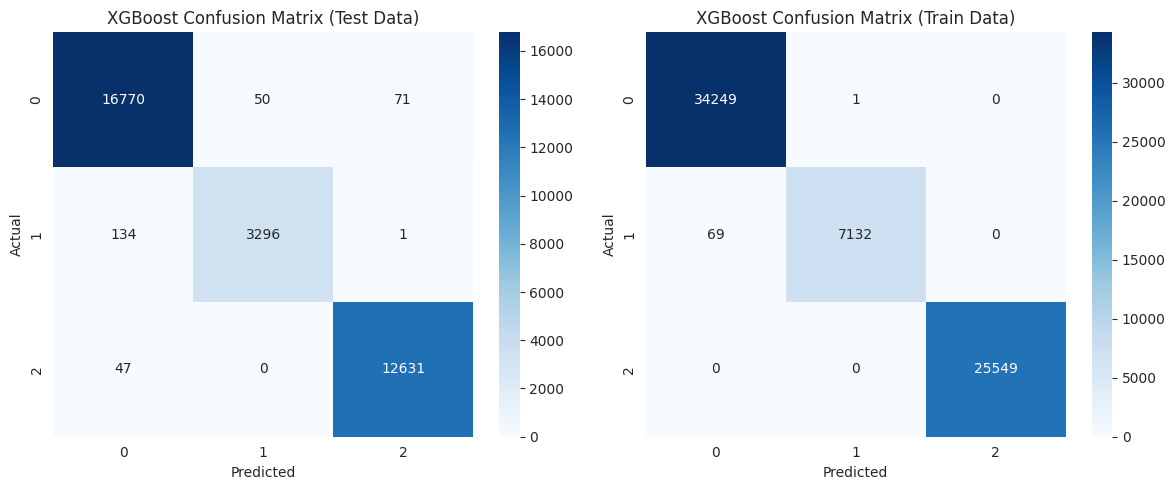

In [ ]:
# Confusion matrix for XGBoost on testing data
cm_xgb_test = confusion_matrix(y_test, preds_test)

# Confusion matrix for XGBoost on training data
cm_xgb_train = confusion_matrix(y_train, preds_train)

# Plot confusion matrices side by side
plt.figure(figsize=(12, 5))

# Plot confusion matrix for XGBoost (Testing Data)
plt.subplot(1, 2, 1)
sns.heatmap(cm_xgb_test, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot confusion matrix for XGBoost (Training Data)
plt.subplot(1, 2, 2)
sns.heatmap(cm_xgb_train, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [ ]:
!pip install --upgrade scikit-plot

In [ ]:
rfc = RandomForestClassifier(n_estimators=10)

training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds_test = rfc.predict(X_test)
prediction_end = time.perf_counter()

prediction_start = time.perf_counter()
preds_train = rfc.predict(X_train)
prediction_end = time.perf_counter()

acc_rfc_test = (preds_test == y_test).sum().astype(float) / len(preds_test)*100
acc_rfc_train = (preds_train == y_train).sum().astype(float) / len(preds_train)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start

print("Scikit-Learn's Random Forest Classifier's prediction accuracy for training data is: %3.2f" % (acc_rfc_train))
print("Scikit-Learn's Random Forest Classifier's prediction accuracy testing data is: %3.2f" % (acc_rfc_test))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

#import scikitplot.estimators as esti
#esti.plot_learning_curve(rfc, X_train, y_train)
#plt.show()

Scikit-Learn's Random Forest Classifier's prediction accuracy for training data is: 99.90
Scikit-Learn's Random Forest Classifier's prediction accuracy testing data is: 99.07
Time consumed for training: 3.262 seconds
Time consumed for prediction: 0.09238 seconds


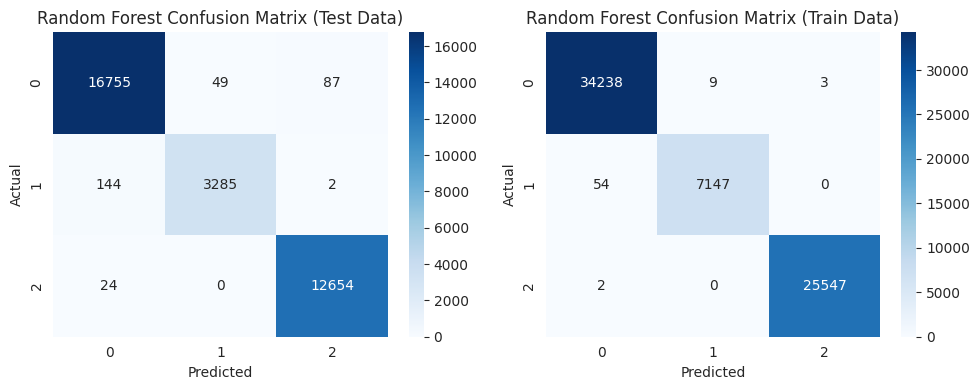

In [ ]:
# Confusion matrix for Random Forest
cm_rfc_test = confusion_matrix(y_test, rfc.predict(X_test))
cm_rfc_train = confusion_matrix(y_train, rfc.predict(X_train))

# Plot confusion matrix for Random Forest (Test Data)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_rfc_test, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Test Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot confusion matrix for Random Forest (Train Data)
plt.subplot(1, 2, 2)
sns.heatmap(cm_rfc_train, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix (Train Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [ ]:
results = pd.DataFrame({'Model': ['XGBoost', 'Random Forest'],
    'Score': [acc_xgb_test, acc_rfc_test],
    'Runtime Training': [xgb_train_time, rfc_train_time],
    'Runtime Prediction': [xgb_prediction_time, rfc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,99.081818,2.396112,0.357650
Random Forest,99.072727,3.262222,0.092381


In [ ]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99253731 0.99134328 0.99074627 0.98955224 0.98970149 0.98880597
 0.99044776 0.99       0.99074627 0.99119403]
Mean: 0.9905074626865671
Standard Deviation: 0.0010061074356031436


In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99149254 0.99074627 0.98970149 0.99       0.98970149 0.98970149
 0.99059701 0.98895522 0.99179104 0.99134328]
Mean: 0.990402985074627
Standard Deviation: 0.0008881537639887772


In [ ]:
importances = pd.DataFrame({
    'Feature': new_df.drop('class', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
redshift,0.950100
PCA_3,0.014153
PCA_2,0.008077
PCA_1,0.005798
plate,0.005078
mjd,0.005039
ra,0.004452
fiberid,0.003694
dec,0.003608


<Axes: xlabel='Feature'>

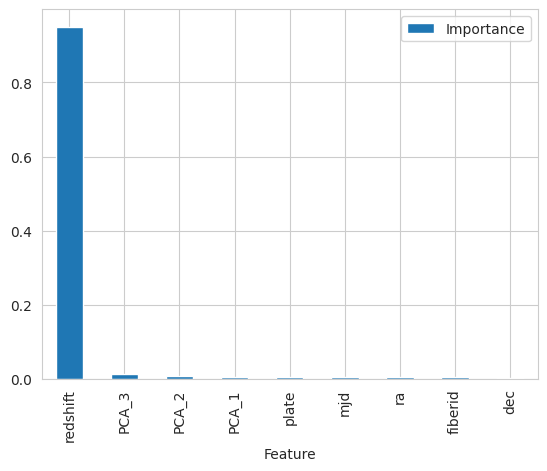

In [ ]:
importances.plot.bar()

In [ ]:
scaler = MinMaxScaler()
sdss = pd.DataFrame(scaler.fit_transform(new_df.drop(['mjd', 'class'], axis=1)), columns=new_df.drop(['mjd', 'class'], axis=1).columns)
sdss['class'] = new_df['class']

In [ ]:
sdss.head(10)

,ra,dec,redshift,plate,fiberid,PCA_1,PCA_2,PCA_3,class
0,0.596583,0.439741,0.002775,0.151535,0.026026,0.447173,0.225065,0.433665,0
1,0.530483,0.472428,0.015359,0.160492,0.116116,0.527009,0.149991,0.433186,0
2,0.619158,0.418916,0.006259,0.152919,0.566567,0.430556,0.233852,0.435231,0
3,0.586752,0.447208,0.023067,0.151209,0.234234,0.440336,0.205445,0.440545,0
4,0.608513,0.645211,0.000566,0.114649,0.415415,0.506598,0.310927,0.432490,2
5,0.615091,0.636274,0.000570,0.669571,0.511512,0.431785,0.251022,0.427931,2
6,0.623895,0.624246,0.000566,0.114811,0.460460,0.391479,0.275987,0.412800,2
7,0.628390,0.618365,0.000538,0.254377,0.346346,0.450876,0.227933,0.430633,2
8,0.630584,0.615359,0.000560,0.672014,0.575576,0.474787,0.288508,0.431011,2
9,0.632546,0.611426,0.000536,0.254377,0.148148,0.534963,0.284943,0.430149,2


Finding the best hyperparameters

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sdss.drop('class', axis=1), sdss['class'], test_size=0.33)

In [ ]:
xgboost = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0,min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 99.02


In [ ]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99179104 0.99208955 0.98925373 0.99119403 0.98985075 0.99029851
 0.99179104 0.98940299 0.98985075 0.98940299]
Mean: 0.9904925373134328
Standard Deviation: 0.001057597238092963


In [ ]:
#Confusion Matrix
unique, counts = np.unique(sdss['class'], return_counts=True)
dict(zip(unique, counts))

{0: 51141, 1: 10632, 2: 38227}

In [ ]:
predictions = cross_val_predict(xgb, sdss.drop('class', axis=1), sdss['class'], cv=3)
confusion_matrix(sdss['class'], predictions)

array([[50790,   186,   165],
       [  394, 10232,     6],
       [  151,     0, 38076]])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest Classifier
rfc = RandomForestClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Train RFC with best parameters
best_rfc = RandomForestClassifier(**best_params)
best_rfc.fit(X_train, y_train)

# Evaluate RFC on test data
preds = best_rfc.predict(X_test)
accuracy = (preds == y_test).sum().astype(float) / len(preds) * 100
print("RFC's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))


RFC's prediction accuracy WITH optimal hyperparameters is: 99.06
